In [11]:
import os
from collections import Counter

# Path to your dataset
dataset_dir = "adhd200_Filtered"

# List all top-level subfolders (subjects)
subjects = [d for d in os.listdir(dataset_dir) 
            if os.path.isdir(os.path.join(dataset_dir, d))]

print(f"Found {len(subjects)} subjects in {dataset_dir}\n")

# Iterate over each subject folder
for subj in subjects:
    subj_path = os.path.join(dataset_dir, subj)
    file_counter = Counter()

    # Walk recursively through subject folder
    for root, dirs, files in os.walk(subj_path):
        for f in files:
            ext = os.path.splitext(f)[1].lower()  # get file extension
            file_counter[ext] += 1

    print(f"Location: {subj}")
    for ext, count in file_counter.items():
        print(f"  {ext or 'no_ext'}: {count} files")
    print("-" * 40)
    
# Print summary of file types across all locations
print("\nSummary of all file types:")
all_file_counter = Counter()
for location in subjects:
    loc_path = os.path.join(dataset_dir, location)
    for root, dirs, files in os.walk(loc_path):
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            all_file_counter[ext] += 1

for ext, count in sorted(all_file_counter.items()):
    print(f"{ext or 'no_ext'}: {count} files")
print(f"\nTotal files: {sum(all_file_counter.values())}")

Found 9 subjects in adhd200_Filtered

Location: KKI
  .csv: 6 files
  .tsv: 2 files
  .nii: 82 files
----------------------------------------
Location: NeuroIMAGE
  .csv: 6 files
  .tsv: 2 files
  .nii: 73 files
----------------------------------------
Location: NYU
  .csv: 6 files
  .tsv: 2 files
  .nii: 252 files
----------------------------------------
Location: OHSU
  .csv: 6 files
  .tsv: 2 files
  .nii: 101 files
----------------------------------------
Location: Peking_1
  .csv: 6 files
  .tsv: 2 files
  .nii: 135 files
----------------------------------------
Location: Peking_2
  .csv: 6 files
  .tsv: 2 files
  .nii: 67 files
----------------------------------------
Location: Peking_3
  .csv: 6 files
  .tsv: 2 files
  .nii: 40 files
----------------------------------------
Location: Pittsburgh
  .csv: 6 files
  .tsv: 2 files
  .nii: 86 files
----------------------------------------
Location: WashU
  .csv: 6 files
  .tsv: 2 files
  .nii: 60 files
--------------------------------

In [12]:
import os
import pandas as pd

# Path to your filtered ADHD200 dataset
dataset_dir = "adhd200_Filtered"

# Prepare a list to hold data rows
rows = []

# Loop over location folders
for location in os.listdir(dataset_dir):
    loc_path = os.path.join(dataset_dir, location)
    if not os.path.isdir(loc_path):
        continue
    
    # Load participants.tsv
    tsv_path = os.path.join(loc_path, "participants.tsv")
    if not os.path.exists(tsv_path):
        print(f"Warning: participants.tsv not found in {location}")
        continue
    
    try:
        participants_df = pd.read_csv(tsv_path, sep="\t", encoding="utf-8")
    except UnicodeDecodeError:
        participants_df = pd.read_csv(tsv_path, sep="\t", encoding="latin1")   
         
    # Loop over subject folders
    for subj in os.listdir(loc_path):
        subj_path = os.path.join(loc_path, subj)
        if not os.path.isdir(subj_path) or not subj.startswith("sub-"):
            continue
        
        # Find the 128 normalized resampled .nii file
        nii_files = [f for f in os.listdir(subj_path) if "normalized_resampled_128" in f and f.endswith(".nii")]
        if len(nii_files) == 0:
            print(f"Warning: No normalized_128 nii found for {subj} in {location}")
            continue
        
        # Assume one nii file per subject
        nii_file = nii_files[0]
        nii_path = os.path.join(subj_path, nii_file)
        
        # Match participant_id in participants.tsv
        participant_id = subj.split("-")[1]  # 'sub-1018959' -> '1018959'
        part_row = participants_df[participants_df["participant_id"].astype(str) == participant_id]
        if part_row.empty:
            print(f"Warning: Participant {participant_id} not found in {location}/participants.tsv")
            continue
        
        dx = part_row["dx"].values[0]
        # Treat any type of ADHD as 1
        adhd_label = 1 if "ADHD" in str(dx) else 0
        
        # Append row
        rows.append({
            "location": location,
            "participant_id": participant_id,
            "nii_path": nii_path,
            "ADHD": adhd_label
        })

# Convert to DataFrame
df = pd.DataFrame(rows)
print("Dataset summary:")
print(df.head())
print(f"\nTotal subjects: {len(df)}")

# Optional: save to CSV
df.to_csv("adhd200_128_normalized_labels.csv", index=False)


Dataset summary:
  location participant_id                                           nii_path  \
0      KKI        1018959  adhd200_Filtered\KKI\sub-1018959\normalized_re...   
1      KKI        1019436  adhd200_Filtered\KKI\sub-1019436\normalized_re...   
2      KKI        1043241  adhd200_Filtered\KKI\sub-1043241\normalized_re...   
3      KKI        1266183  adhd200_Filtered\KKI\sub-1266183\normalized_re...   
4      KKI        1535233  adhd200_Filtered\KKI\sub-1535233\normalized_re...   

   ADHD  
0     0  
1     1  
2     0  
3     0  
4     0  

Total subjects: 896


C:\Users\janak\AppData\Local\Temp\ipykernel_40276\2133937306.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




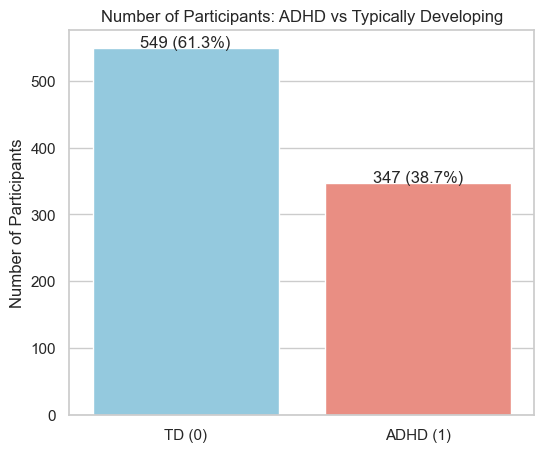

C:\Users\janak\AppData\Local\Temp\ipykernel_40276\2133937306.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




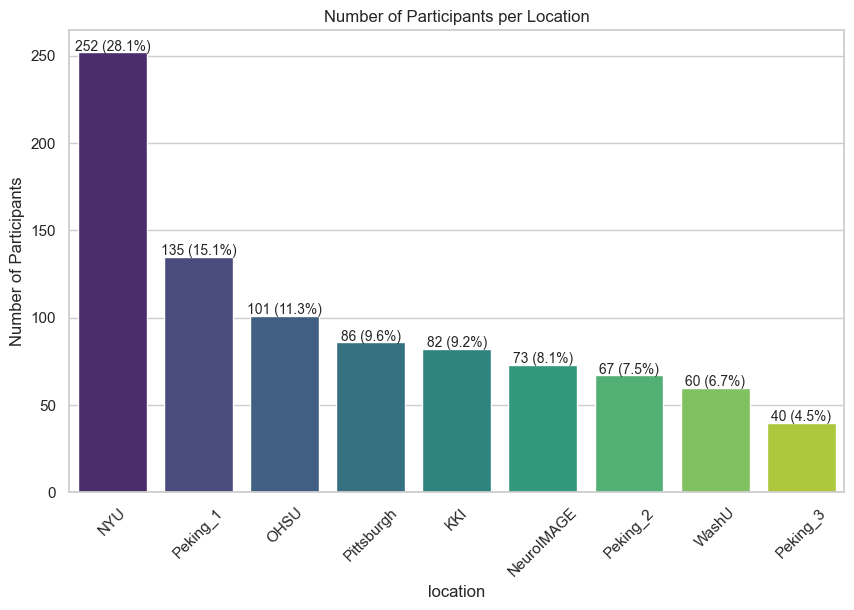

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- 1️⃣ ADHD vs Typically Developing (TD) ---

# Count per label
adhd_counts = df['ADHD'].value_counts().sort_index()
labels = ['TD (0)', 'ADHD (1)']
counts = [adhd_counts.get(0, 0), adhd_counts.get(1, 0)]
percentages = [c / sum(counts) * 100 for c in counts]

# Bar plot
plt.figure(figsize=(6,5))
sns.barplot(x=labels, y=counts, palette=['skyblue','salmon'])
for i, (c, p) in enumerate(zip(counts, percentages)):
    plt.text(i, c + 1, f"{c} ({p:.1f}%)", ha='center', fontsize=12)
plt.title("Number of Participants: ADHD vs Typically Developing")
plt.ylabel("Number of Participants")
plt.show()


# --- 2️⃣ Participants per Location ---

loc_counts = df['location'].value_counts()
loc_percent = loc_counts / loc_counts.sum() * 100

plt.figure(figsize=(10,6))
sns.barplot(x=loc_counts.index, y=loc_counts.values, palette="viridis")
for i, (c, p) in enumerate(zip(loc_counts.values, loc_percent)):
    plt.text(i, c + 1, f"{c} ({p:.1f}%)", ha='center', fontsize=10)
plt.title("Number of Participants per Location")
plt.ylabel("Number of Participants")
plt.xticks(rotation=45)
plt.show()


In [14]:
visualizeSubject = 10
df.iloc[visualizeSubject]

location                                                        KKI
participant_id                                              1652369
nii_path          adhd200_Filtered\KKI\sub-1652369\normalized_re...
ADHD                                                              0
Name: 10, dtype: object

Image shape: (128, 128, 128)
Intensity range: min=-0.41, max=10.13


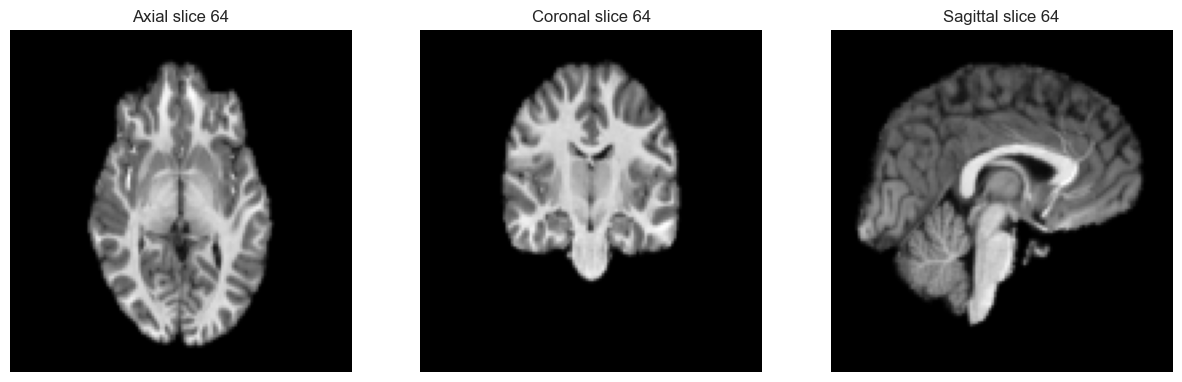

In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# -------------------------------
# Load a NIfTI file (replace with your path)
nii_path = df.iloc[visualizeSubject]['nii_path']
img = nib.load(nii_path)
data = img.get_fdata()  # 3D numpy array

print(f"Image shape: {data.shape}")
print(f"Intensity range: min={data.min():.2f}, max={data.max():.2f}")

# -------------------------------
# 1️⃣ 2D Slice Visualization

# Function to plot slices in axial, coronal, sagittal planes
def plot_slices(volume, slice_indices=None):
    if slice_indices is None:
        # Default: middle slices
        slice_indices = (volume.shape[0]//2, volume.shape[1]//2, volume.shape[2]//2)
    axial = volume[:, :, slice_indices[2]]
    coronal = volume[:, slice_indices[1], :]
    sagittal = volume[slice_indices[0], :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(np.rot90(axial), cmap="gray")
    axes[0].set_title(f'Axial slice {slice_indices[2]}')
    axes[0].axis('off')

    axes[1].imshow(np.rot90(coronal), cmap="gray")
    axes[1].set_title(f'Coronal slice {slice_indices[1]}')
    axes[1].axis('off')

    axes[2].imshow(np.rot90(sagittal), cmap="gray")
    axes[2].set_title(f'Sagittal slice {slice_indices[0]}')
    axes[2].axis('off')

    plt.show()

plot_slices(data)

# -------------------------------
# 2️⃣ 3D Volume Visualization (using Plotly)

# Downsample volume for faster plotting (optional)
factor = 2  # reduce size by factor
data_ds = data[::factor, ::factor, ::factor]

# Create 3D surface plot using volume rendering
fig = go.Figure(data=go.Volume(
    x=np.arange(data_ds.shape[0]).repeat(data_ds.shape[1]*data_ds.shape[2]),
    y=np.tile(np.arange(data_ds.shape[1]).repeat(data_ds.shape[2]), data_ds.shape[0]),
    z=np.tile(np.arange(data_ds.shape[2]), data_ds.shape[0]*data_ds.shape[1]),
    value=data_ds.flatten(),
    opacity=0.1,       # adjust for transparency
    surface_count=25,  # number of isosurfaces
    colorscale='Gray'
))

fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
    aspectmode='data'
))
fig.show()


## Save dataset in BIDS-like format for model training
This cell will create a BIDS-style directory structure with a `participants.tsv` and subject folders containing their T1w MRI in `anat/`.

In [21]:
import os
import pandas as pd
import shutil

# Output BIDS-like directory
bids_dir = 'ADHD_BIDS'
os.makedirs(bids_dir, exist_ok=True)

# Split dataset into train/val/test (80/10/10)
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['ADHD'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1111, stratify=train_val_df['ADHD'], random_state=42)  # 0.1111*0.9 ≈ 0.1

# Assign dataset column
df_bids = df.copy()
df_bids['dataset'] = 'train'
df_bids.loc[val_df.index, 'dataset'] = 'val'
df_bids.loc[test_df.index, 'dataset'] = 'test'

# Prepare participants.tsv
participants_tsv = pd.DataFrame({
    'participant_id': df_bids['participant_id'],
    'label': df_bids['ADHD'],
    'dataset': df_bids['dataset']
})
participants_tsv.to_csv(os.path.join(bids_dir, 'participants.tsv'), sep='\t', index=False)

# Copy/organize files
for _, row in df_bids.iterrows():
    pid = row['participant_id']
    src_nii = row['nii_path']
    subj_dir = os.path.join(bids_dir, f'sub-{pid}', 'anat')
    os.makedirs(subj_dir, exist_ok=True)
    # Output filename: <participant_id>_T1w.nii.gz
    out_nii = os.path.join(subj_dir, f'{pid}_T1w.nii.gz')
    # Copy and compress if needed
    if src_nii.endswith('.gz'):
        shutil.copy2(src_nii, out_nii)
    else:
        import nibabel as nib
        img = nib.load(src_nii)
        nib.save(img, out_nii)

print(f'BIDS-like dataset saved to: {bids_dir}')

BIDS-like dataset saved to: ADHD_BIDS
